In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy
import torch
from sklearn import metrics

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import itertools
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
def get_starts(chrom_list, step = 5e4):
    startl = []
    chroml = []
    for chrom in chrom_list:
        chrom = 'chr{}'.format(chrom)
        cur_starts = list(np.arange(start_dict[chrom],end_dict[chrom]-5000000, step).astype(int))
        startl = startl + cur_starts
        chroml = chroml + list(np.repeat(chrom, len(cur_starts)))
    return startl, chroml

def get_visualization(y_hat_list,y_true_list,avg_stripes = False):
    y_hat_list_reshaped = np.concatenate([x.reshape(1,-1) for x in y_hat_list[start_ind_origami:start_ind_origami+plot_len]], axis = 0)
    y_true_list_reshaped = np.concatenate([x.reshape(1,-1) for x in y_true_list[start_ind_origami:start_ind_origami+plot_len]], axis = 0)
    mat = []
    mat_ytrue = []
    for i in range(plot_len):
        mat.append(np.insert(np.zeros(plot_len), i, y_hat_list_reshaped[i]))
        mat_ytrue.append(np.insert(np.zeros(plot_len), i, y_true_list_reshaped[i].clip(-16,16)))
    if avg_stripes:
        summed = (pd.DataFrame(np.array(mat)).reindex(np.arange(-1*pred_len,plot_len+1,1)).fillna(0).iloc[0:plot_len+pred_len+1,0:plot_len+pred_len+1].values+pd.DataFrame(np.array(mat)).reindex(
        np.arange(-1*pred_len,plot_len+1,1)).fillna(0).T.iloc[0:plot_len+pred_len+1,0:plot_len+pred_len+1].values)/2
    else:
        summed = pd.DataFrame(np.array(mat)).reindex(np.arange(-1*pred_len,plot_len+1,1)).fillna(0).T.iloc[0:plot_len+pred_len+1,0:plot_len+pred_len+1].values
                  
    comb = np.zeros((summed.shape[0],summed.shape[0]))

    comb[np.triu_indices(comb.shape[0])[0],np.triu_indices(comb.shape[0])[1]] = (summed[np.triu_indices(comb.shape[0])[0],
                                                    np.triu_indices(comb.shape[0])[1]])
    comb[np.tril_indices(comb.shape[0],k = -1)[0],np.tril_indices(comb.shape[0],k = -1)[1]] = 0

    return comb

def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
def get_combined_yhat(y_hat_list, start_ind, end_ind, offset = 200, avg_stripe = False): 
    pred_len = 200
    y_hat_list_reshaped = np.concatenate([x.reshape(1,-1) for x in y_hat_list[start_ind:end_ind]], axis = 0)
    chrom_length = y_hat_list_reshaped.shape[0]
    mat = []

    for i in tqdm(range(chrom_length)):
        mat.append(np.insert(np.zeros(chrom_length+offset+1), i, np.insert(y_hat_list_reshaped[i],pred_len,0)))
    summed = pd.DataFrame(
    np.array(mat)).reindex(np.arange(-1*pred_len,chrom_length,1)
        ).fillna(0).T.iloc[0:chrom_length+pred_len,0:chrom_length+pred_len].values
    
    if avg_stripe:
        summed = (pd.DataFrame(np.array(mat)).reindex(np.arange(-1*pred_len,chrom_length,1)
                ).fillna(0).iloc[0:chrom_length+pred_len,0:chrom_length+pred_len].values+pd.DataFrame(
            np.array(mat)).reindex(np.arange(-1*pred_len,chrom_length,1)
                ).fillna(0).T.iloc[0:chrom_length+pred_len,0:chrom_length+pred_len].values)/2
    summed = summed[200:-200,200:-200] # remove padded region

    return summed

def get_metacell_profile(tile_dict, nbrs):
    metacell_tile_dict = {}
    metacell = nbrs
    for chrom in list(tile_dict.keys()):
        metacell_tile_dict[chrom] = (scipy.sparse.csr_matrix(metacell) * tile_dict[chrom])
    return metacell_tile_dict 

def cpu_jaccard_vstripe(x):
    size = x.shape[1]
    eps=1e-8
    i = 2

    x = torch.where(x>0.0, torch.tensor([1.0]), torch.tensor([0.0]))
    num = torch.mm(x, x.transpose(0,1))
    
    x = torch.where(x==0.0, torch.tensor([1.0]), torch.tensor([0.0]))
    denom = torch.mm(x, x.transpose(0,1))
    denom = size - denom

    num = torch.div(num, torch.max(denom, eps * torch.ones_like(denom)))
    
    return num

def cpu_batch_corcoeff_vstripe(x):
    c = cpu_jaccard_vstripe(x.permute(1,0))
    c[c != c] = 0
    return c

def get_preds(chroms, path):

    y_z_hat_list = []
    tmp = []
    for chrom in chroms:
        tmp.append(np.load(path + '{}.npz'.format(chrom))['arr_0'])
    tmp = np.concatenate([y for y in tmp], axis = 0)
    y_z_hat_list.append(tmp)
    y_z_hat_list = np.concatenate([np.expand_dims(y,1) for y in y_z_hat_list], axis = 1)

    return y_z_hat_list

def pcolormesh_45deg(C,vmax,vmin):
    n = C.shape[0]
    # create rotation/scaling matrix
    t = np.array([[1,0.5],[-1,0.5]])
    # create coordinate matrix and transform it
    A = np.dot(np.array([(i[1],i[0]) for i in itertools.product(range(n,-1,-1),range(0,n+1,1))]),t)
    # plot
    img = plt.pcolormesh(A[:,1].reshape(n+1,n+1),A[:,0].reshape(n+1,n+1),np.flipud(C),
                  cmap = 'RdBu_r',
                         vmax = vmax, vmin = vmin
                        )
    return img
    

In [5]:
ct = 'imr90'
genome = 'hg38'
mod = 'gmetahic'

In [6]:
# Load Hi-C data for evaluation

hicdc = pickle.load(open("./gmetahic/datasets/hic/zvalue/{}/hic_zscore_dict.p".format(ct,ct), "rb"))


In [7]:
# # Load input data for visualization
ctcf_motif = pickle.load(open("./gmetahic/datasets/dna/{}_ctcf_motif_score.p".format(genome), 'rb'))
atac = pickle.load(open("./gmetahic/datasets/atac/{}/{}_tile_pbulk_50bp_dict.p".format(ct,ct), 'rb'))
scatac = pickle.load(open("./gmetahic/datasets/atac/{}/{}_tile_500bp_dict.p".format(ct,ct), 'rb'))
metacell_path = pd.read_csv('./gmetahic/datasets/atac/{}/{}_metacell_mask.csv'.format(ct,ct), index_col= 0).values
scatac = get_metacell_profile(scatac, metacell_path)

# Quantitative Evaluation

In [8]:
chrom = '5'

In [9]:
hicdc_mat = hicdc['chr{}'.format(chrom)].toarray()
# hicdc_pval_mat = pval['chr{}'.format(chrom)].toarray()

In [14]:
# Get predictions
# y_hat = get_preds([chrom], './predictions/prediction_{}_chr'.format(ct))


# chengxj
y_hat = get_preds([chrom], './gmetahic/predictions/2025-05-25_20h_transformer_prediction_3cells_imr90_chr'.format(ct,ct))


In [13]:
# Evaluate
pearson_list = {}
spearman_list = {}
roc_list = {}
prc_list = {}

# Get ground-truth Hi-C data
true_mat = hicdc_mat[:-501,:-501].clip(-16,16)
min_len = len(np.diag(true_mat,199)) # Compute shortest diagonal length

# Significant interaction analysis
percentile_cutoff = 90 # Zscore percentile cutoff for significant interactions
bin_true = np.concatenate([np.diag(true_mat,i)[0:min_len] for i in range(1,200)]).reshape(-1, min_len)
bin_mask = (bin_true.sum(0) >= np.percentile(bin_true.sum(0),1)) #mask for low-mappability regions
all_zval = np.concatenate([np.diag(true_mat,i)[0:min_len] for i in range(1,200)])
zval_cutoff = np.percentile(all_zval, percentile_cutoff)
bin_zval = all_zval > zval_cutoff
print('Positive class proportion: {}'.format(bin_zval.sum()/bin_zval.shape[0]))
print('Zval cutoff: {}'.format(zval_cutoff))

# Get processed predictions
pred_mat = get_combined_yhat(y_hat[:,0,:], start_ind = 0, end_ind = y_hat.shape[0], avg_stripe=True)
print("pred_mat.shape:",pred_mat.shape)

pearson_list[mod] = []
spearman_list[mod] = []
roc_list[mod] = []
prc_list[mod] = []

for i in range(1,200):
    a = np.diag(true_mat,i)[0:min_len][bin_mask]
    b = np.diag(pred_mat,i)[0:min_len][bin_mask]
    p = np.diag(true_mat,i)[0:min_len][bin_mask] > zval_cutoff
    
    fpr, tpr, thresholds = metrics.roc_curve(p.astype(int), b)
    precision, recall, thresholds = metrics.precision_recall_curve(p.astype(int), b)
    pearson_list[mod].append(scipy.stats.pearsonr(a,b)[0])    
    spearman_list[mod].append(scipy.stats.spearmanr(a,b)[0])    
    roc_list[mod].append(metrics.auc(fpr, tpr))
    prc_list[mod].append(metrics.auc(recall, precision))
    


Positive class proportion: 0.10000011516272782
Zval cutoff: 1.17763165


100%|██████████| 17653/17653 [00:01<00:00, 14193.77it/s]


pred_mat.shape: (17453, 17453)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 17452 but corresponding boolean dimension is 17454

(0.0, 1.0)

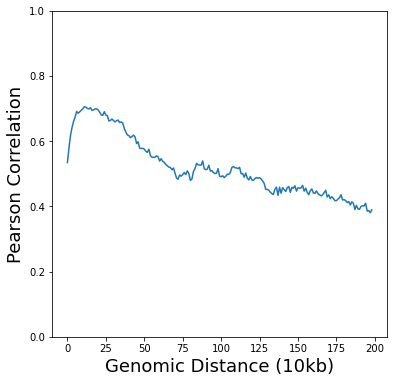

In [14]:
plt.rcParams['figure.figsize'] = 6,6
plt.plot(pearson_list[mod], label = mod)
# plt.legend()
plt.ylabel('Pearson Correlation', fontsize = 18)
plt.xlabel('Genomic Distance (10kb)', fontsize = 18)
plt.ylim(0,1)

(0.0, 1.0)

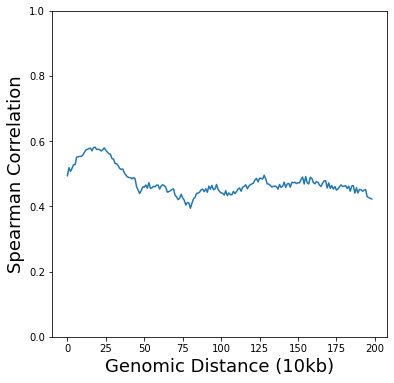

In [15]:
plt.rcParams['figure.figsize'] = 6,6
plt.plot(spearman_list[mod], label = mod)
# plt.legend()
plt.ylabel('Spearman Correlation', fontsize = 18)
plt.xlabel('Genomic Distance (10kb)', fontsize = 18)
plt.ylim(0,1)

(0.0, 1.0)

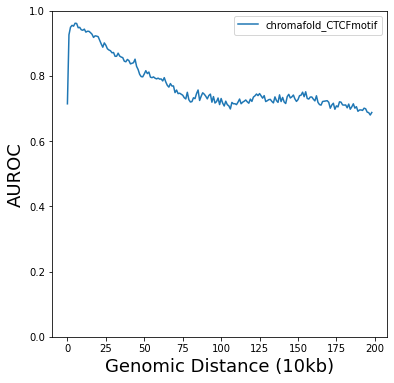

In [16]:
plt.rcParams['figure.figsize'] = 6,6
plt.plot(roc_list[mod], label = mod)
plt.legend()
plt.ylabel('AUROC', fontsize = 18)
plt.xlabel('Genomic Distance (10kb)', fontsize = 18)
plt.ylim(0,1)

(0.0, 1.0)

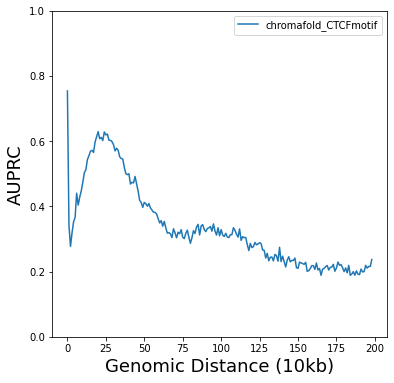

In [17]:
plt.rcParams['figure.figsize'] = 6,6
plt.plot(prc_list[mod], label = mod)
plt.legend()
plt.ylabel('AUPRC', fontsize = 18)
plt.xlabel('Genomic Distance (10kb)', fontsize = 18)
plt.ylim(0,1)

# Visualize

In [18]:
pred_mat = get_combined_yhat(y_hat[:,0,:], start_ind = 0, end_ind = y_hat.shape[0], avg_stripe=True)


100%|██████████| 9520/9520 [00:00<00:00, 16862.47it/s]


In [57]:
start = 2000


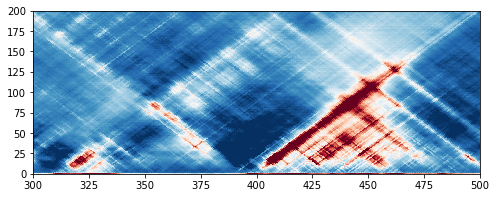

In [109]:
# Prediction
plt.rcParams['figure.figsize'] = 8, 3
img = pcolormesh_45deg(np.triu(pred_mat[start:start+700,start:start+700]), 4,-1)
plt.ylim(0,200)
plt.xlim(300,500)
plt.show()


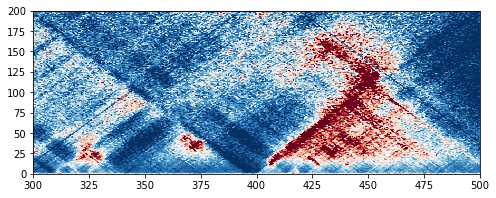

In [110]:
# Ground Truth
img = pcolormesh_45deg(np.triu(hicdc_mat[start:start+700,start:start+700]), 7,-1)
plt.ylim(0,200)
plt.xlim(300,500)
plt.show()

Text(0, 0.5, 'CTCF motif score')

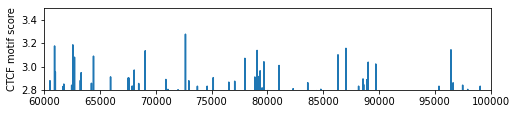

In [111]:
plt.rcParams['figure.figsize'] = 8, 1.5
plt.plot(ctcf_motif['chr{}'.format(chrom)].toarray()[0][(start)*200 : (start+700)*200])
plt.xlim(60000, 100000)
plt.ylim(2.8,3.5)
plt.ylabel('CTCF motif score')


Text(0, 0.5, 'ATAC-seq signal')

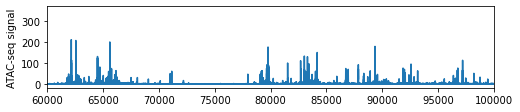

In [112]:
plt.plot(atac['chr{}'.format(chrom)][(start)*200 : (start+700)*200])
plt.xlim(60000, 100000)
# plt.ylim(2.8,3.5)
plt.ylabel('ATAC-seq signal')